In [49]:
import pyspark
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, dayofweek, hour, avg, count, desc

In [2]:
spark = SparkSession.builder \
    .appName("NYCYellowTaxiAnalysis") \
    .getOrCreate()

In [72]:
# Load dataset
df = spark.read.parquet("data/yellow_tripdata_2025-01.parquet", header=True, inferSchema=True)

### Basic Data Exploration

In [68]:
print(f"Number of rows: {df.count()}")
df.printSchema()
df.describe("passenger_count", "trip_distance", "total_amount").show()

Number of rows: 3475226
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)

+-------+------------------+-----------------+------------------+
|summary|   passenger_count|    tri

In [16]:
# Data Cleaning
df = df.filter(
    (col("trip_distance") > 0) &
    (col("fare_amount") > 0) &
    (col("passenger_count").between(1, 6))
)

In [18]:
# Temporal Analysis (hourly trips)
hourly_trips = df.withColumn("pickup_hour", hour("tpep_pickup_datetime")) \
    .groupBy("pickup_hour") \
    .count() \
    .orderBy("pickup_hour")

hourly_trips.show(24)
# hourly_trips.toPandas().plot(x="pickup_hour", y="count", kind="bar")  # For visualization


+-----------+------+
|pickup_hour| count|
+-----------+------+
|          0| 65123|
|          1| 43681|
|          2| 29457|
|          3| 19146|
|          4| 12330|
|          5| 15376|
|          6| 34876|
|          7| 74157|
|          8|105864|
|          9|122244|
|         10|133609|
|         11|144633|
|         12|157095|
|         13|165943|
|         14|178804|
|         15|188209|
|         16|190745|
|         17|206976|
|         18|205987|
|         19|174654|
|         20|157907|
|         21|161520|
|         22|134143|
|         23| 94346|
+-----------+------+



<Axes: xlabel='pickup_hour'>

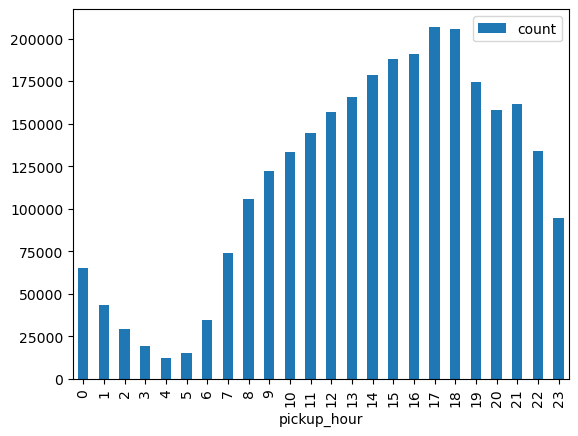

In [20]:
hourly_trips.toPandas().plot(x="pickup_hour", y="count", kind="bar")

### Observations from above
#### Peak Hours:

Morning Rush: 8 AM to 10 AM (8–10): Steady increase from 105,864 to 133,609 trips.

Evening Rush: 5 PM (17) has the highest count (206,976), likely due to commuters heading home.

Midday: 12 PM–3 PM (12–15): High activity (157,095–188,209), possibly from lunchtime errands or business travel.

#### Lowest Activity:

4 AM (4): Only 12,330 trips (quietest hour).

3 AM (3): 19,146 trips, reflecting late-night inactivity.

#### Unexpected Patterns:

5 AM (5): A small spike (15,376) after 4 AM’s low, possibly due to early airport trips or shift workers.

9 PM (21): Slight increase (161,520) compared to 8 PM (157,907), likely from nightlife or events.



In [32]:
# Fare vs. Distance Analysis
fare_distance_stats = df.groupBy("passenger_count") \
    .agg(
        avg("trip_distance").alias("avg_distance"),
        avg("total_amount").alias("avg_total_amount")
    )
fare_distance_stats.show()

+---------------+------------------+------------------+
|passenger_count|      avg_distance|  avg_total_amount|
+---------------+------------------+------------------+
|              6| 3.090298682775396|26.368257404144682|
|              5|2.9642779322476316|26.054086704874287|
|              1| 3.125728609079176|27.079292845809334|
|              3|3.5089576762351378|29.606928025687875|
|              2|3.7005294650768015|30.246608996538143|
|              4|3.8281838094368994|31.940923610477252|
+---------------+------------------+------------------+



### Observations from above

#### Non-Linear Relationship:

Passenger count 1: Highest average total fare ($27.08) despite a moderate distance (3.13 miles).

Passenger count 4: Longest average distance (3.83 miles) and highest total fare ($31.94).

Passenger counts 5–6: Lower averages compared to smaller groups (e.g., 6 passengers: $26.37 total fare for 3.09 miles).

#### Unexpected Patterns:

Trips with 2 passengers have a higher average fare ($30.25), than trips with 3 passengers ($29.61), even though the distance for 3 passengers is shorter.

Single-passenger trips generate higher revenue than larger groups (5–6 passengers).

#### 1. Segment by Trip Type (Airport vs. City Rides)

In [51]:
# Classify airport vs. city trips
df = df.withColumn(
    "trip_type",
    when(col("RatecodeID").isin(2, 3), "airport").otherwise("city")
)

# Aggregate by passenger_count and trip_type
airport_city_stats = df.groupBy("passenger_count", "trip_type") \
    .agg(
        avg("trip_distance").alias("avg_distance"),
        avg("total_amount").alias("avg_total_amount"),
        count("*").alias("trip_count")
    ) \
    .orderBy("passenger_count", "trip_type")

airport_city_stats.show()

+---------------+---------+------------------+------------------+----------+
|passenger_count|trip_type|      avg_distance|  avg_total_amount|trip_count|
+---------------+---------+------------------+------------------+----------+
|              1|  airport|17.739476217253195| 95.81405695950016|     60464|
|              1|     city|2.7223117156340075| 25.18184903099232|   2190304|
|              2|  airport|17.710339707622463| 94.65383831443663|     26199|
|              2|     city|2.7023379148672344|25.657628063572663|    367708|
|              3|  airport|17.617690506598567| 97.43000851426193|      4698|
|              3|     city|  2.71157028571429| 25.77375109774447|     83125|
|              4|  airport|17.480593900481548| 93.86353130016099|      3115|
|              4|     city|3.0051287013741117|28.207830462550888|     51670|
|              5|  airport|18.126771217712182| 94.69586715867152|       542|
|              5|     city| 2.483154382061939|23.876003161407418|     17081|

### Observations from above

#### Airport Rides:
##### Longer Distance, Higher Fare:

- All airport trips (regardless of passenger count) have ~17–18 miles average distance and ~$93–97 total fare.

  Likely due to fixed routes (e.g., NYC to JFK/Newark airports is ~17–20 miles).

##### Fixed Pricing:

- Minimal fare variation across passenger counts (e.g., 1 passenger: $95.81, 6 passengers: $93.72).

  Suggests flat-rate pricing for airport trips (common in NYC).


#### City Rides:
##### Shorter Distance, Lower Fare:

- Average city trip distance ranges from 2.5–3 miles with fares $23–28.

  Higher passenger counts (4) correlate with slightly longer distances and higher fares.

##### Passenger Count Impact:

- Trips with 4 passengers have the highest city fare ($28.21), likely due to longer leisure trips (e.g., family outings).

  5–6 passengers show lower fares ($23–24) despite similar distances, hinting at discounts for group rides.


#### Airport vs. City Trip Economics:
##### Revenue Contribution:

- Airport rides are high-value (e.g., 1 passenger airport ride: $95.81 vs. city ride: $25.18).

  However, city rides dominate volume (e.g., 1 passenger: 2.1M city trips vs. 60K airport trips).

##### Passenger Behavior:

- Solo travelers and pairs (1–2 passengers) dominate airport rides, while larger groups (5–6) are rare.

  Groups of 4 are the most common for city rides with higher spending.


#### Group Size Dynamics:
##### City Rides:

- 4 passengers: Highest fare ($28.21), likely due to family trips or events.

  5–6 passengers: Lower fares despite similar distances, suggesting discounts (e.g., shared ride promotions).

##### Airport Rides:

- No fare premium for larger groups—flat pricing makes them less cost-effective per person for groups.

#### Data Skew:
##### Sample Size:

- Very few airport trips for groups of 5–6 (e.g., 6 passengers: only 480 airport trips).

  City trips with 5–6 passengers are also sparse (11K–17K trips), making averages less reliable.



#### 2. Time-of-Day Analysis for 5–6 Passenger Trips

+----------+-----------+-----+
|is_weekend|pickup_hour|count|
+----------+-----------+-----+
|         0|          0|  373|
|         0|          1|  225|
|         0|          2|  128|
|         0|          3|   65|
|         0|          4|   61|
|         0|          5|  149|
|         0|          6|  312|
|         0|          7|  723|
|         0|          8|  979|
|         0|          9| 1070|
|         0|         10| 1082|
|         0|         11| 1140|
|         0|         12| 1148|
|         0|         13| 1225|
|         0|         14| 1383|
|         0|         15| 1436|
|         0|         16| 1470|
|         0|         17| 1682|
|         0|         18| 1565|
|         0|         19| 1307|
|         0|         20| 1274|
|         0|         21| 1324|
|         0|         22| 1059|
|         0|         23|  692|
|         1|          0|  350|
|         1|          1|  267|
|         1|          2|  163|
|         1|          3|  126|
|         1|          4|   56|
|       

<Axes: xlabel='pickup_hour', ylabel='count'>

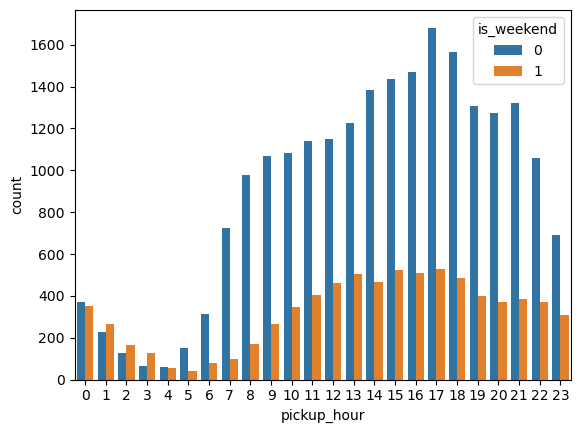

In [55]:
# Filter for 5–6 passenger trips and extract hour/weekday
df_5_6 = df.filter(col("passenger_count").isin(5, 6)) \
    .withColumn("pickup_hour", hour("tpep_pickup_datetime")) \
    .withColumn("is_weekend", when(dayofweek("tpep_pickup_datetime").isin(1, 7), 1).otherwise(0))

# Hourly distribution on weekends vs. weekdays
peak_hour_analysis = df_5_6.groupBy("is_weekend", "pickup_hour") \
    .count() \
    .orderBy("is_weekend", "pickup_hour")

peak_hour_analysis.show(48)

# For visualization (Pandas-compatible):
pd_df = peak_hour_analysis.toPandas()
sns.barplot(x="pickup_hour", y="count", hue="is_weekend", data=pd_df)

### Observations from above

#### 1. Weekday Patterns (is_weekend=0):
<b>Morning Rush:</b> Peaks at 8 AM (979 trips) and 5 PM (1,682 trips) align with typical work commutes.

- Suggests groups of 5–6 passengers carpooling to workplaces or schools.

<b>Midday Lull:</b> Lower activity between 10 AM–3 PM compared to weekends.

<b>Late-Night Drop:</b> Trips plummet after 10 PM, hitting a low at 4 AM (61 trips).

#### 2. Weekend Patterns (is_weekend=1):
<b>Nightlife Surge:</b> Higher late-night activity at 12–3 AM (e.g., 350 trips at midnight vs. 373 on weekdays).

- Likely groups traveling to/from parties, bars, or events.

<b>Afternoon Peaks:</b> Gradual rise to 3 PM (505 trips) and 5 PM (529 trips).

- Matches leisure activities (e.g., family outings, shopping).

<b>No Morning Rush:</b> Low activity at 5–8 AM (e.g., 40 trips at 5 AM vs. 149 on weekdays).

#### 3. Critical Contrasts:
##### Weekday Focus:

<b>Commute-Driven:</b> 5–6 passenger trips cluster around work hours (7–9 AM and 4–7 PM).

<b>Lunchtime Dip:</b> Fewer trips during midday compared to weekends.

#### Weekend Focus:

<b>Nightlife and Leisure:</b> Sustained activity from noon to midnight, with no sharp drop-off.

<b>No Rush Hours:<b> Traffic is distributed more evenly.

### Recommendations from above analysis

##### Target Weekday Commuters:

- Offer group discounts during rush hours (7–9 AM and 4–7 PM) to incentivize carpooling.

- Partner with offices/schools to promote shared rides.

##### Weekend Nightlife Strategy:

- Increase driver availability in entertainment districts (e.g., bars, concert venues) during 10 PM–2 AM.

- Run promotions like "Weekend Group Rides" with free upgrades to larger vehicles.

##### Midday Weekend Opportunities:

- Advertise family-friendly packages (e.g., "Weekend Family Outing Discounts") for 3–5 PM slots.



#### 3. Fare Component Breakdown

In [45]:
# Assuming columns: fare_amount, extra (surcharges), mta_tax, tip_amount, tolls_amount
fare_component_analysis = df.groupBy("passenger_count") \
    .agg(
        avg("fare_amount").alias("avg_fare"),
        avg("extra").alias("avg_surcharge"),
        avg("mta_tax").alias("avg_tax"),
        avg("tip_amount").alias("avg_tip"),
        avg("tolls_amount").alias("avg_tolls"),
        avg("total_amount").alias("avg_total")
    ) \
    .orderBy("passenger_count")

fare_component_analysis.show()

+---------------+------------------+------------------+-------------------+------------------+-------------------+------------------+
|passenger_count|          avg_fare|     avg_surcharge|            avg_tax|           avg_tip|          avg_tolls|         avg_total|
+---------------+------------------+------------------+-------------------+------------------+-------------------+------------------+
|              1|17.778546784919776|1.6330467778109519| 0.4967127887014566| 3.437333865595925|0.47695200482691363|27.079292845809334|
|              2|20.166688025346307|1.5023116623974693| 0.4938919592695738|3.8293876473383524| 0.7296543346527125|30.246608996538143|
|              3|19.855320701866226| 1.426144631816267| 0.4895813169670815|3.6066296983705284| 0.7339446386481736|29.606928025687875|
|              4| 22.18569644975815| 1.336063703568495| 0.4784156247147942|3.6018098019530265| 0.7821478506890364|31.940923610477252|
|              5| 16.85873063610056|1.0461896385405436|0.49724

#### 1. Geospatial Analysis: Identify Hotspots

In [57]:
# Load Taxi Zone Lookup Data (from NYC TLC)
taxi_zone_df = spark.read.csv("taxi_zone_lookup.csv", header=True, inferSchema=True)

# Join with trip data to get pickup zone names
df_with_zones = df.join(
    taxi_zone_df,
    df.PULocationID == taxi_zone_df.LocationID,
    "left"
).select(
    "passenger_count",
    "tpep_pickup_datetime",
    "PULocationID",
    "Zone",  # Name of the pickup zone 
    "Borough",
)

# Analyze weekday morning rush (7–9 AM) in business districts
weekday_business_hotspots = df_with_zones.filter(
    (dayofweek("tpep_pickup_datetime").between(2, 6)) &  # Weekdays (Mon-Fri)
    (hour("tpep_pickup_datetime").between(7, 9))
).groupBy("Zone", "Borough").count().orderBy(desc("count"))
print("Weekday Business Hotspots")
weekday_business_hotspots.show(10, truncate=False)

# Analyze weekend nightlife (10 PM–2 AM) in entertainment zones
weekend_nightlife_hotspots = df_with_zones.filter(
    (dayofweek("tpep_pickup_datetime").isin(1, 7)) &  # Weekend (Sat/Sun)
    (hour("tpep_pickup_datetime").between(22, 23) |  # 10 PM–11:59 PM
     hour("tpep_pickup_datetime").between(0, 2)      # 12 AM–2 AM
)).groupBy("Zone", "Borough").count().orderBy(desc("count"))

print("Weekend Nightlife Hotspots")
weekend_nightlife_hotspots.show(10, truncate=False)

Weekday Business Hotspots
+----------------------------+---------+-----+
|Zone                        |Borough  |count|
+----------------------------+---------+-----+
|Upper East Side North       |Manhattan|20338|
|Upper East Side South       |Manhattan|14934|
|Penn Station/Madison Sq West|Manhattan|13987|
|Midtown East                |Manhattan|10602|
|Lenox Hill East             |Manhattan|8946 |
|Upper West Side South       |Manhattan|8834 |
|Lenox Hill West             |Manhattan|8492 |
|Murray Hill                 |Manhattan|8306 |
|Midtown Center              |Manhattan|8211 |
|Upper West Side North       |Manhattan|8197 |
+----------------------------+---------+-----+
only showing top 10 rows

Weekend Nightlife Hotspots
+----------------------------+---------+-----+
|Zone                        |Borough  |count|
+----------------------------+---------+-----+
|East Village                |Manhattan|12311|
|West Village                |Manhattan|9995 |
|Greenwich Village South    

#### Observation from above analysis

##### Weekday Business Hotspots
##### Key Observations:
<b>Dominant Borough:</b> All top 10 zones are in Manhattan, reflecting its role as NYC’s business hub.

##### Key Zones:

 - <b>Upper East Side North/South:</b> Affluent residential and commercial areas with corporate offices.

 - <b>Penn Station/Midtown West:</b> Major transit hub for commuters (e.g., NJ/Long Island commuters).

 - <b>Midtown East:</b> Headquarters of multinational firms (e.g., UN, Bloomberg LP).

 - <b>Pattern:</b> High demand aligns with 9-to-5 work schedules and commuting peaks.


##### Weekend Nightlife Hotspots
##### Key Observations:
##### Nightlife Zones:

 - <b>East Village, West Village, Greenwich Village:</b> Bars, clubs, and restaurants drive demand.

 - <b>Lower East Side:</b> Known for trendy nightlife venues.

#### Unexpected Zone:

 - <b>JFK Airport (Queens):</b> Likely reflects weekend leisure travel (e.g., tourists arriving/departing).

#### Entertainment Zones:

 - <b>Times Sq/Theatre District:</b> Weekend shows and tourism.

### Recommendations

 - <b>Driver Allocation:</b> Prioritize surge pricing and driver availability in these zones during 7–9 AM and 4–7 PM.

 - <b>Corporate Partnerships:</b> Partner with offices to offer subsidized commuter rides.

 - <b>Nightlife Focus:</b> Increase driver availability in nightlife zones during 10 PM–2 AM.

 - <b>Airport Coordination:</b> Partner with airlines to promote taxi vouchers for weekend travelers.

#### 2. Pricing Breakdown: Weekday vs. Weekend Fares

In [59]:

fare_comparison = df.withColumn(
    "is_weekend",
    dayofweek("tpep_pickup_datetime").isin(1, 7).cast("int")
).groupBy("is_weekend", "passenger_count").agg(
    avg("total_amount").alias("avg_total"),
    avg("fare_amount").alias("avg_fare"),
    avg("tolls_amount").alias("avg_tolls"),
    avg("tip_amount").alias("avg_tip")
).orderBy("is_weekend", "passenger_count")

fare_comparison.show()

+----------+---------------+------------------+------------------+-------------------+------------------+
|is_weekend|passenger_count|         avg_total|          avg_fare|          avg_tolls|           avg_tip|
+----------+---------------+------------------+------------------+-------------------+------------------+
|         0|              1|27.383209081797354|17.911561103579242|  0.478820117600684| 3.469618123119002|
|         0|              2|31.211753343789862| 20.74590581622734| 0.7916406325510423|3.9261816093323265|
|         0|              3|31.115031739015222|20.853860666607705| 0.8421909645477745|3.7581418088585887|
|         0|              4| 34.07601764428204|23.740204473031973| 0.9325876312994175| 3.779516405051314|
|         0|              5|  26.4467931998137| 16.97991849091757|  0.411502095947836| 3.486924390622574|
|         0|              6|26.528863181312538|17.323781979977724|  0.401490545050057|3.4527007786429382|
|         1|              1| 26.04762987361654

#### Observation from above analysis

##### 1. Fare Trends by Passenger Count:
##### Weekdays:

- <b>Peak at 4 Passengers</b>: Highest avg_total (34.08) and avg_fare (23.74),        likely due to longer business/family trips
- <b> Sharp Drop for 5-6 Passengers</b>: Lower totals (26.45-26.53), suggesting        discounts or shorter trips (e.g shared ride).

##### Weekends:
- <b>Lower Overall Fares</b>: All passenger counts have lower totals vs weekdays      (e.g., 4 passengers: 28.48 vs 34.08).
- <b>Similar Drop for 5–6 Passengers</b>: Consistent with weekday discounts but at lower absolute values.

##### 2. Fare Components:
##### Tolls:
- Higher on weekdays (e.g., 4 passengers: 0.93 vs. 0.54 on weekends), likely due to commuters using toll roads.

##### Tips:
- Weekday tips peak at <b>2 passengers</b> ($3.93), possibly from business travelers.
- Weekend tips are lower overall (max $3.62 for 2 passengers), reflecting leisure trips with smaller tips.

##### 3. Weekend vs. Weekday Comparison:
##### 1 Passenger:
- Weekday total = $27.38 | Weekend = $26.05
- Likely solo business travelers paying more on weekdays.
##### 4 Passengers:
- Weekday total = $34.08 | Weekend = $28.48
- Indicates premium pricing for weekday group trips (e.g., airport rides).


### Recommendations

#### Optimize Group Pricing:

 - Promote discounts for 5–6 passengers during off-peak hours to fill empty      seats.

 - Charge premiums for 4-passenger weekday rides (high-value segment).

#### Driver Incentives:

 - Encourage drivers to accept 4-passenger rides during weekday rush hours.

 - Highlight toll-heavy routes to maximize earnings.

#### Customer Targeting:

 - Market weekday commuter packages to businesses.

 - Offer weekend family/group discounts to boost demand.


